In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
import tqdm
import seaborn as sns
import bisect

/Users/leopere/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:

def perturb_normal_mixture(orig_means, orig_variances, orig_weights, 
                           comp_out=100, alpha=500):
    """
    Returns a perturbation of a mixture:
    
    Given a mixture
            f(y) = \sum_j w_j N(y | \mu_j, \Sigma_j)
    returns
            f'(y) = \sum_k w'_k N(y | \mu'_j, 0.2^2 * I)
    where
    1. mu'_k are the new location centers, obtained by sampling
            c_k ~ Categorical(w_1, .. w_J)
            mu'_k | c_k ~ N(mu_{c_k}, \Sigma_{c_k})
              for k=1, ... comp_out
    2. w'_k are normalized weights (sum to 1) and their length
       is `comp_out` 
           w_k ~ Dirichlet(alpha/comp_out)
    
    """
    univariate = len(orig_means.shape) == 1
    
    c_ks = np.random.choice(
        len(orig_weights), size=comp_out, replace=True, p=orig_weights)
    
    if univariate:
        locations = tfd.Normal(orig_means[c_ks], np.sqrt(orig_variances)[c_ks]).sample()
        variances = np.ones(comp_out) * 0.2 ** 2
    else:
        locations = tfd.MultivariateNormalFullCovariance(
            orig_means[c_ks], np.sqrt(orig_variances)[c_ks]).sample()
        variances = np.stack([np.eye(orig_means.shape[1]) * 1 ** 2] * comp_out)
    weights = tfd.Dirichlet(np.ones(comp_out) * alpha / comp_out).sample()
    return locations, variances, weights

def eval_univariate_mixture_dens(locations, variances, weights, xgrid):
    eval_comps = tfd.Normal(locations, np.sqrt(variances)).prob(xgrid[:, np.newaxis])
    return np.sum(eval_comps * weights, axis=1)

def eval_multivariate_mixture_dens(locations, variances, weights, xgrid):
    eval_comps = tfd.MultivariateNormalFullCovariance(locations, np.sqrt(variances)).prob(xgrid[:, np.newaxis])
    return np.sum(eval_comps * weights, axis=1)


In [ ]:
#Univariate Data
true_mu = np.array([-3.5, 3, 0, 6])
true_sigma = np.array([0.8, 0.5, 0.4, 0.5]) ** 2
w_t = np.array([0.25, 0.25, 0.3, 0.2])
xgrid = np.linspace(-10, 10, 1000)

pert_mu, pert_sigma, pert_w = perturb_normal_mixture(true_mu, true_sigma, w_t)
plt.plot(xgrid, eval_univariate_mixture_dens(true_mu, true_sigma, w_t, xgrid))
plt.plot(xgrid, eval_univariate_mixture_dens(pert_mu, pert_sigma, pert_w , xgrid))




#Univariate Sampling
summed_pert_w = [ sum(pert_w[:x]) for x in range(0, len(pert_w))]
s = np.random.uniform(0,1,1000)
idx_to_sample=[bisect.bisect_left(summed_pert_w, sample)-1 for sample in s]
sampled_df = np.array([tfd.Normal(pert_mu[idx], pert_sigma[idx]).sample() for idx in idx_to_sample])

sns.histplot(data=sampled_df)
sns.kdeplot(data=sampled_df)

/Users/leopere/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


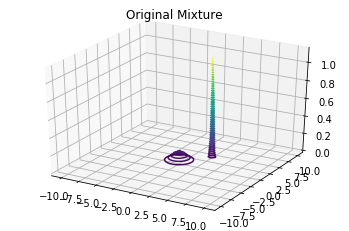

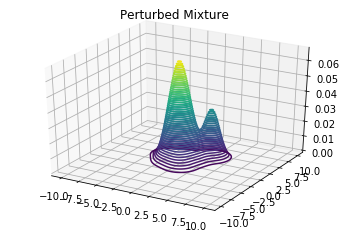

In [80]:
################
#Choose shape for true data in multivariate case
################

n_samples = 1000

#Multivariate Data
true_mu_bi = np.array([  [0,0] , [3,3]  ])
true_sigma_bi = np.array([  [[1,0] , [0, 1]] ,   [[0.0005 , 0] , [0 , 0.0005]] ])
w_t_bi = np.array([0.8, 0.2])
grid_1D = np.linspace(-10, 10, 100)
grid_2D = np.array([[x0, y0] for x0 in grid_1D for y0 in grid_1D])
X,Y = np.meshgrid(grid_1D,grid_1D) 

#Few components otherwise computations are very long
#Also the grid of points is less refined
pert_mu_bi, pert_sigma_bi, pert_w_bi = perturb_normal_mixture(true_mu_bi, true_sigma_bi, w_t_bi,comp_out = 100)



fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y,np.reshape(eval_multivariate_mixture_dens(true_mu_bi, true_sigma_bi, w_t_bi, grid_2D), newshape = X.shape) , 50, cmap='viridis')
ax.set_title('Original Mixture');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y,np.reshape(eval_multivariate_mixture_dens(pert_mu_bi, pert_sigma_bi, pert_w_bi, grid_2D), newshape = X.shape) , 50, cmap='viridis')
ax.set_title('Perturbed Mixture');


#Multivariate Sampling from perturbed densities
chosen_components = tfd.Categorical(probs = pert_w_bi).sample(n_samples)
samples = []
for i in range(len(chosen_components)):
    samples.append(tfd.MultivariateNormalFullCovariance(pert_mu_bi[chosen_components[i]], pert_sigma_bi[chosen_components[i]]).sample())
    
    
#"Assign" each of the components to one of the original mixture components, otherwise i dont know to which cluster
#should one point be part, only knowing it comes from for example the 70th perturbed component
#I do this looking at the distance for each component mean to the original means

# dist = [0 for i in range(len(w_t_bi))]
# assigned_comp = []
# for mean in pert_mu_bi:
#     for i in range(len(dist)):
#         dist[i] = np.linalg.norm(mean - true_mu_bi[i])
        
#     assigned_comp.append(np.argmin(dist))

# assigned_point = [assigned_comp[chosen_components[i]] for i in range(n_samples) ]
    
sampled_df = np.array(samples)





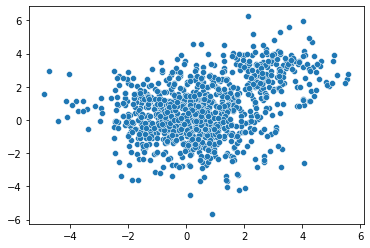

In [81]:
sns.scatterplot(x=[elem[0] for elem in sampled_df], y=[elem[1] for elem in sampled_df])

In [82]:
np.save('test2.npy', sampled_df)

In [ ]:
#evaluation of the mixtures
z_true = np.reshape(eval_multivariate_mixture_dens(true_mu_bi, true_sigma_bi, w_t_bi, grid_2D), newshape = X.shape)
z_pert = np.reshape(eval_multivariate_mixture_dens(pert_mu_bi, pert_sigma_bi, pert_w_bi, grid_2D), newshape = X.shape)

In [ ]:
#plot 3D of the distributions with plotly
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=z_pert, x=X, y=Y,colorscale=[[0, 'rgb(194,207,249)'], [1, 'rgb(76,115,241)']],lighting=dict(diffuse=0.1,ambient=0.9,fresnel=4.5))])

fig.update_layout(title='Perturbed distributions', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

fig = go.Figure(data=[go.Surface(z=z_true, x=X, y=Y,colorscale=[[0, 'rgb(194,207,249)'], [1, 'rgb(76,115,241)']],lighting=dict(diffuse=0.1,ambient=0.9,fresnel=4.5))])
fig.update_layout(title='True distributions', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [ ]:
#Multivariate Sampling from non-perturbed densities
chosen_components = tfd.Categorical(probs = w_t_bi).sample(1000)
samples = []
for i in range(len(chosen_components)):
    samples.append(tfd.MultivariateNormalFullCovariance(true_mu_bi[chosen_components[i]], true_sigma_bi[chosen_components[i]]).sample())
    

sampled_df = np.array(samples)
np.save('sampled_2D_two_clusters_true.npy', sampled_df)

In [ ]:
true = np.reshape(eval_multivariate_mixture_dens(true_mu_bi, true_sigma_bi, w_t_bi, grid_2D), newshape = X.shape)

In [ ]:
perturbed = np.reshape(eval_multivariate_mixture_dens(pert_mu_bi, pert_sigma_bi, pert_w_bi, grid_2D), newshape = X.shape)

In [6]:
np.save('sampled_2D_two_clusters_near.npy', sampled_df)